In [97]:
# FashionMnist VQ experiment with various settings.
# From https://github.com/minyoungg/vqtorch/blob/main/examples/autoencoder.py

from tqdm.auto import trange

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from vector_quantize_pytorch import VectorQuantize


lr = 3e-4
train_iter = 1000
num_codes = 256
seed = 1234
device = "cuda" if torch.cuda.is_available() else "cpu"


class SimpleVQAutoEncoder(nn.Module):
    def __init__(self, **vq_kwargs):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.GELU(),
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.MaxPool2d(kernel_size=2, stride=2),
                VectorQuantize(dim=32, accept_image_fmap = True, **vq_kwargs),
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
                nn.GELU(),
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
            ]
        )
        return

    def forward(self, x):
        for layer in self.layers:
            if isinstance(layer, VectorQuantize):
                x, indices, commit_loss = layer(x)
            else:
                x = layer(x)

        return x.clamp(-1, 1), indices, commit_loss


def train(model, train_loader, train_iterations=1000, alpha=10):
    def iterate_dataset(data_loader):
        data_iter = iter(data_loader)
        while True:
            try:
                x, y = next(data_iter)
            except StopIteration:
                data_iter = iter(data_loader)
                x, y = next(data_iter)
            yield x.to(device), y.to(device)

    for _ in (pbar := trange(train_iterations)):
        opt.zero_grad()
        x, _ = next(iterate_dataset(train_loader))
        out, indices, cmt_loss = model(x)
        rec_loss = (out - x).abs().mean()
        (rec_loss + alpha * cmt_loss).backward()

        opt.step()
        pbar.set_description(
            f"rec loss: {rec_loss.item():.3f} | "
            + f"cmt loss: {cmt_loss.item():.3f} | "
            + f"active %: {indices.unique().numel() / num_codes * 100:.3f}"
        )
    return


transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
train_dataset = DataLoader(
    datasets.FashionMNIST(
        root="~/data/fashion_mnist", train=True, download=True, transform=transform
    ),
    batch_size=256,
    shuffle=True,
)

print("baseline")
torch.random.manual_seed(seed)
model = SimpleVQAutoEncoder(codebook_size=num_codes).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=lr)
train(model, train_dataset, train_iterations=train_iter)

baseline


  0%|          | 0/1000 [00:00<?, ?it/s]

rec loss: 0.122 | cmt loss: 0.001 | active %: 21.484: 100%|██████████| 1000/1000 [01:13<00:00, 13.54it/s]


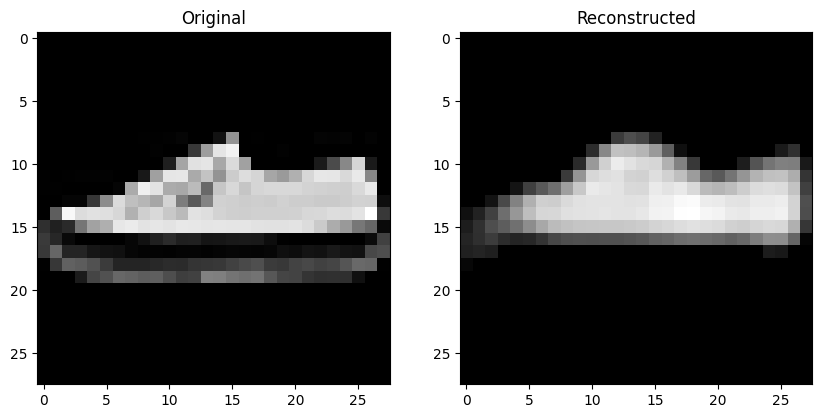

In [116]:
# Predict with trained model
import matplotlib.pyplot as plt

x, _ = next(iter(train_dataset))
out, _, _ = model(x.to(device))
out = out.detach().cpu()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(x[0].squeeze(), cmap="gray")
axs[0].set_title("Original")
axs[1].imshow(out[0].squeeze(), cmap="gray")
axs[1].set_title("Reconstructed")
plt.show()

Load MiniGrid levels

In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [105]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

class GridsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, grids, pos, img=None):
        self.grids = grids
        self.pos = pos
        self.img = img

    def __len__(self):
        return len(self.grids)

    def __getitem__(self, index):
        x = TF.to_tensor(self.grids[index])
        y = torch.tensor(self.pos[index])
        if self.img is not None:
            img = TF.to_tensor(self.img[index])
            return x, y, img
            print("img")
        return x, y

In [181]:
# Load the data
X = np.load("MiniGrid/grids.npy")
Y = np.load("MiniGrid/pos.npy")
path_lengths = np.load("MiniGrid/path_lengths.npy")

# Un-normalize the data
Y *= 7
Y += 7
Y = Y.astype(int)

# Remove outer walls
X = X[:, 1:-1, 1:-1, :]
Y -= 1

X.shape, Y.shape, path_lengths.shape

((40000, 13, 13, 3), (40000, 4), (40000,))

Process grids

In [182]:
idx = 0

points = []

for idx in range(X.shape[0]):
    # Remove player and goal from the grid
    X[idx, Y[idx, 1], Y[idx, 0], :] = [0, 0, 0]
    X[idx, Y[idx, 3], Y[idx, 2], :] = [0, 0, 0]

    # Extract coordinates of non-zero elements
    x, y = np.where(X[idx].mean(axis=-1) != 0)
    points_ = np.array(list(zip(x, y)))
    # Add player and goal to the points
    points_ = np.concatenate([points_, Y[idx].reshape(-1, 2)])
    points.append(points_)

    if points_.shape[0] != 27:
        print(idx, points_.shape)
        break

    print(f"Processed {idx+1}/{X.shape[0]} grids", end="\r")

points = np.array(points)

In [183]:
X_img = np.copy(X).astype(np.float32)
X = points.astype(np.float32)
Y = path_lengths.astype(np.float32)

# Standardize the data
X -= X.mean()
X /= X.std()
X_img -= X_img.mean()
X_img /= X_img.std()

# One channel
X_img = np.mean(X_img, axis=-1)

In [184]:
import cv2
import PIL

# Resize images to 28x28
X_img_resized = np.zeros((X_img.shape[0], 28, 28))
for i in range(X_img.shape[0]):
    X_img_resized[i] = cv2.resize(X_img[i], (28, 28), interpolation=PIL.Image.NEAREST)

X_img = X_img_resized.astype(np.float32)

In [185]:
# Create training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val, X_img_train, X_img_val, = train_test_split(X, Y, X_img, test_size=0.1, random_state=42)

# Create datasets
train_dataset = GridsDataset(X_train, Y_train, X_img_train)
val_dataset = GridsDataset(X_val, Y_val, X_img_val)

In [186]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Train VQ-VAE

In [198]:
# FashionMnist VQ experiment with various settings.
# From https://github.com/minyoungg/vqtorch/blob/main/examples/autoencoder.py

from tqdm.auto import trange

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from vector_quantize_pytorch import VectorQuantize


lr = 3e-4
train_iter = 20000
num_codes = 128
seed = 1234
device = "cuda" if torch.cuda.is_available() else "cpu"


class SimpleVQAutoEncoder(nn.Module):
    def __init__(self, **vq_kwargs):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.GELU(),
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.MaxPool2d(kernel_size=2, stride=2),
                VectorQuantize(dim=32, accept_image_fmap = True, **vq_kwargs),
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
                nn.GELU(),
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
            ]
        )
        return

    def forward(self, x):
        for layer in self.layers:
            if isinstance(layer, VectorQuantize):
                x, indices, commit_loss = layer(x)
            else:
                x = layer(x)

        return x.clamp(-1, 1), indices, commit_loss


def train(model, train_loader, train_iterations=1000, alpha=10):
    def iterate_dataset(data_loader):
        data_iter = iter(data_loader)
        while True:
            try:
                _, y, x = next(data_iter)
            except StopIteration:
                data_iter = iter(data_loader)
                _, y, x = next(data_iter)
            yield x.to(device), y.to(device)

    losses = []
    for _ in (pbar := trange(train_iterations)):
        opt.zero_grad()
        x, _ = next(iterate_dataset(train_loader))
        out, indices, cmt_loss = model(x)
        rec_loss = (out - x).abs().mean()
        (rec_loss + alpha * cmt_loss).backward()

        opt.step()
        pbar.set_description(
            f"rec loss: {rec_loss.item():.3f} | "
            + f"cmt loss: {cmt_loss.item():.3f} | "
            + f"active %: {indices.unique().numel() / num_codes * 100:.3f}"
        )
        losses.append((rec_loss, cmt_loss))
    return losses

print("baseline")
torch.random.manual_seed(seed)
model = SimpleVQAutoEncoder(codebook_size=num_codes).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=lr)
loss_history = train(model, train_loader, train_iterations=train_iter)

baseline


  0%|          | 0/20000 [00:00<?, ?it/s]

rec loss: 0.369 | cmt loss: 0.000 | active %: 22.656: 100%|██████████| 20000/20000 [05:03<00:00, 65.79it/s]


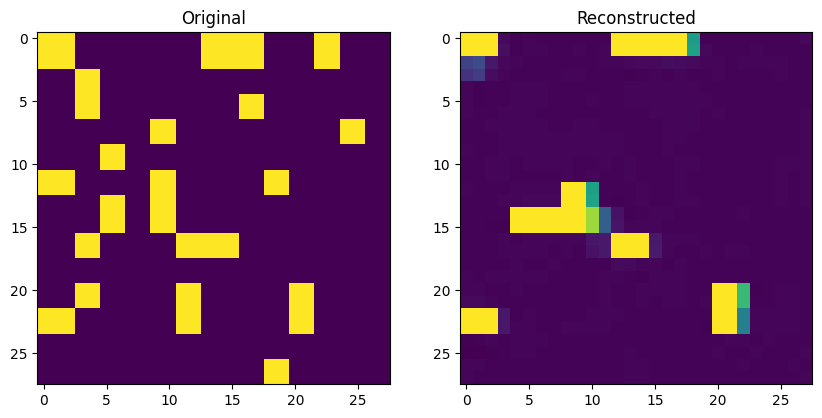

In [201]:
# Predict with trained model
import matplotlib.pyplot as plt

_, _, x = next(iter(train_loader))
out, _, _ = model(x.to(device))
out = out.detach().cpu()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(x[0].squeeze())
axs[0].set_title("Original")
axs[1].imshow(out[0].squeeze())
axs[1].set_title("Reconstructed")
plt.show()